In [1]:
import pandas as pd
import os
import seaborn as sns
import warnings

from load_wastewater_data import load_systems_data
from plotting_tools import *

# Update rcParams to set the default font to Times New Roman
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

In [2]:
# define experiment to be preprocessed
experiment_series = "2024_09_17"

resolution = "3_min_resolution" 
rain_scenario = "KeinRegen" # one of KeinRegen, Nieselregen, MittelstarkerRegen
degradation_setting = "no_decay" # one of "no_decay", "linear_decay_0_0001", "constant_decay_0_025"

In [3]:
plot_path = f"../plots/wastewater_model/correlation"
os.makedirs(os.path.join(plot_path), exist_ok=True)
file_name_prefix = f"{resolution}_{rain_scenario}_{degradation_setting}"

Load data

In [4]:
df_wastewater = load_systems_data(experiment_series, resolution, rain_scenario, degradation_setting, file_type="concentrations")
df_wastewater["hours"] = df_wastewater["minutes"]/60
df_wastewater = df_wastewater[[int(x)==x for x in df_wastewater.hours]] # only subselect full hours

In [12]:
infection_model_output_path = f"../../preprocessing/preprocessed_data/infection_model/{experiment_series}"
df_prevalence = pd.read_csv(os.path.join(infection_model_output_path, "console_output_summarized.csv"))
df_prevalence["inc"] = df_prevalence["S"].diff() * -1

In [9]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

In [10]:
def get_crosscorr_for_one_station(df_combined, sampling_location, lags_in_hours):
    df_combined_sub = df_combined.loc[df_combined.sampling_point==sampling_location, :].sort_values("hours")
    return [crosscorr(df_combined_sub["COVID_copies/l"], df_combined_sub["inc"], lag) for lag in lags_in_hours]

In [16]:
lag_in_hours = 36 
sampling_location = "16"

df_wastewater_sim1 = df_wastewater.loc[df_wastewater['memilio_id'] == 1]
df_prevalence_sim1 = df_prevalence.loc[df_prevalence['memilio_id'] == 1]
df_combined_sim1 = df_wastewater_sim1.merge(df_prevalence_sim1, left_on="hours", right_on="time", how="left")
correlations = get_crosscorr_for_one_station(df_combined_sim1, sampling_location, [-lag_in_hours, 0, lag_in_hours])

In [18]:
df_wastewater_sub = df_combined_sim1.loc[df_combined_sim1['sampling_point'] == sampling_location].sort_values("hours")
df_wastewater_sub.loc[:,"time_in_days"] = df_wastewater_sub.loc[:,"hours"]/24
df_prevalence_sim1.loc[:,"time_in_days"] = df_prevalence_sim1.loc[:,"time"]/24

In [20]:
df_prevalence_sim1.loc[:,"time_in_days_plus_lag"] = df_prevalence_sim1.loc[:,"time_in_days"] + lag_in_hours/24
df_prevalence_sim1.loc[:,"time_in_days_minus_lag"] = df_prevalence_sim1.loc[:,"time_in_days"] - lag_in_hours/24

min_time = df_prevalence_sim1["time_in_days"].min()
max_time = df_prevalence_sim1["time_in_days"].max()

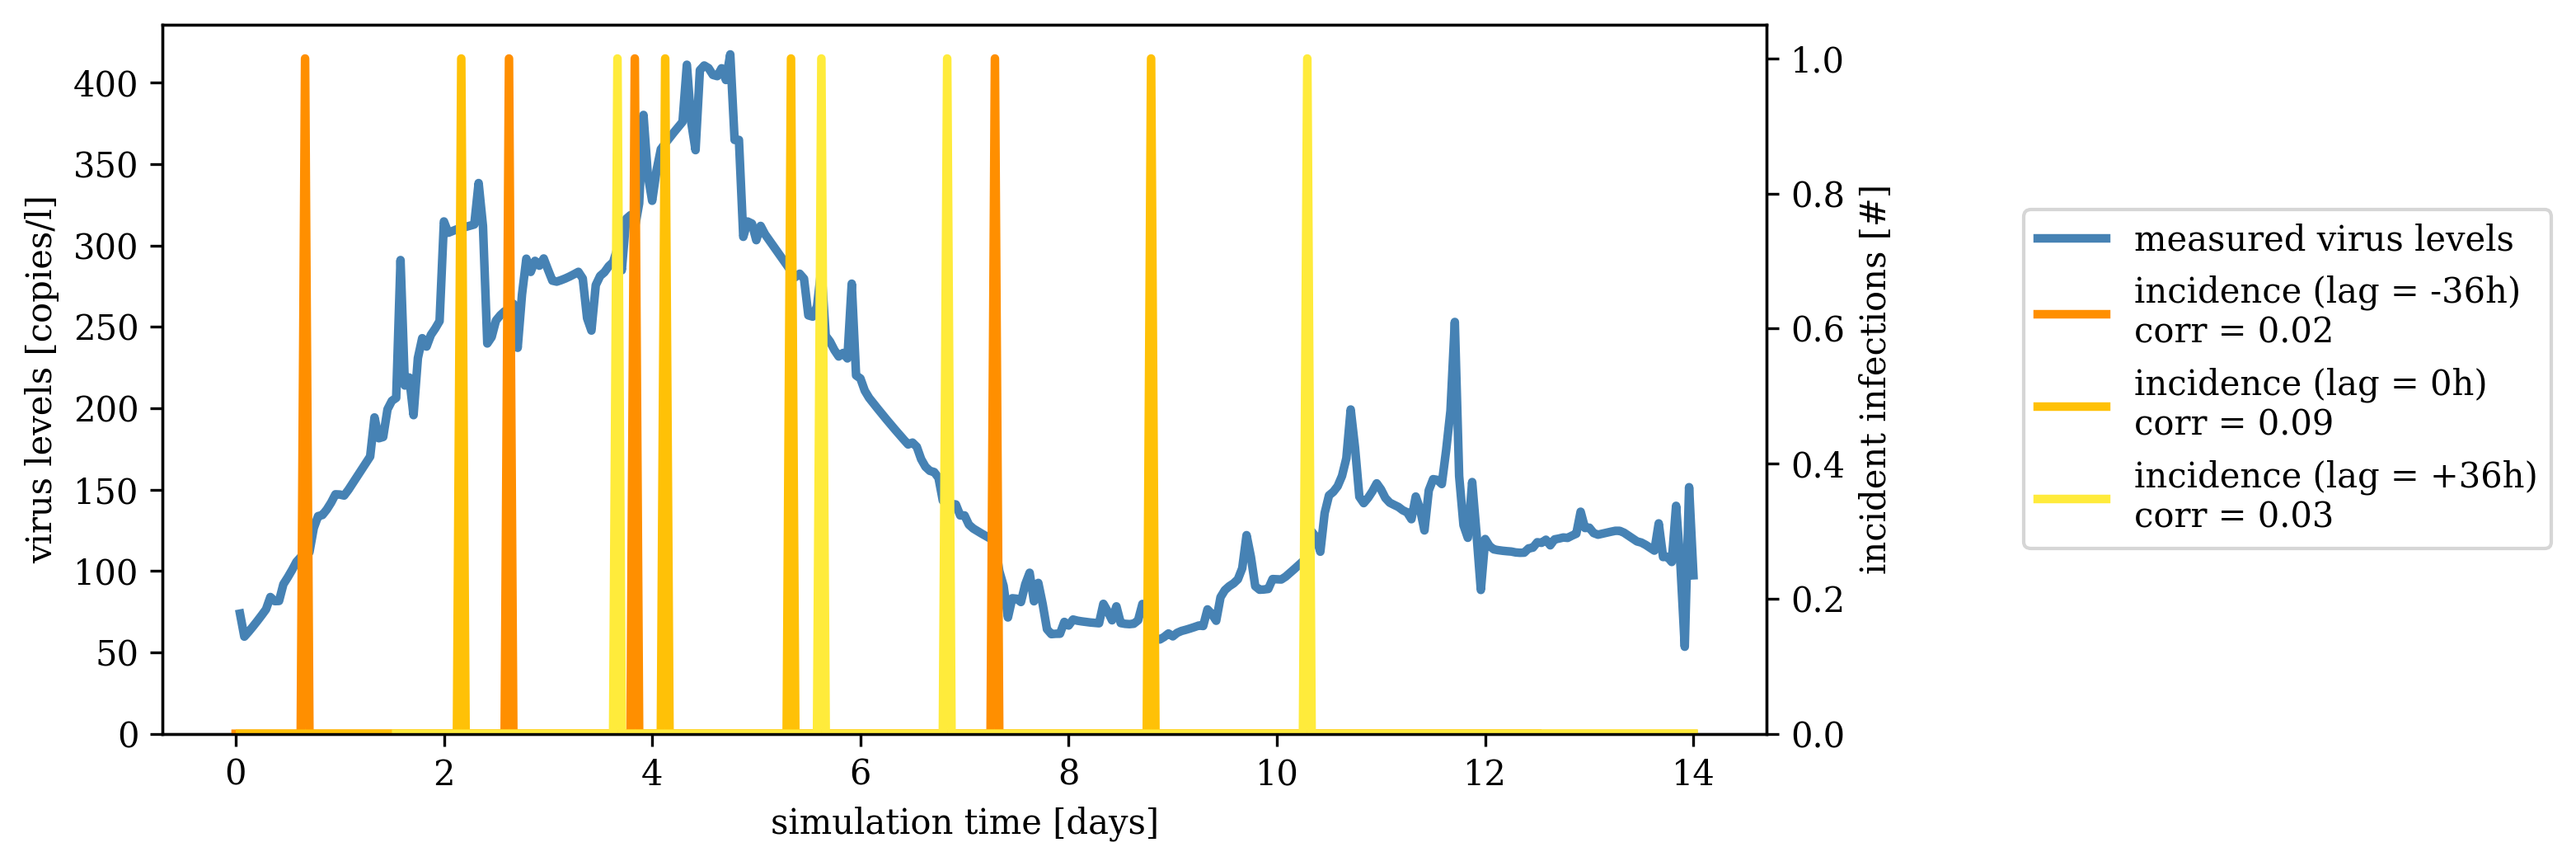

In [21]:
shades_of_yellow = ['#FFEB3B', '#FFC107', '#FF8F00']

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize = (12*0.9,4*0.9), dpi=300)

# Plot copies/l on primary y-axis
sns.lineplot(x=df_wastewater_sub["time_in_days"], y=df_wastewater_sub["COVID_copies/l"], label=f"measured virus levels", ax=ax1, color='steelblue', legend=False, linewidth=2.5)
ax1.set_ylabel('virus levels [copies/l]')
ax1.tick_params(axis='y')
ax1.set_ylim(ymin=0)

# Create secondary y-axis for prevalence
ax2 = ax1.twinx()
# minus lag
df_prevalence_sub = df_prevalence_sim1.loc[(df_prevalence_sim1["time_in_days_minus_lag"] >= min_time) & (df_prevalence_sim1["time_in_days_minus_lag"] <= max_time)]
sns.lineplot(x=df_prevalence_sub["time_in_days_minus_lag"], y=df_prevalence_sub["inc"], label=f"incidence (lag = -{lag_in_hours}h)\ncorr = {correlations[0]:.2f}", ax=ax2, color=shades_of_yellow[2], linewidth=2.5)
# no lag
sns.lineplot(x=df_prevalence_sim1["time_in_days"], y=df_prevalence_sim1["inc"], label=f"incidence (lag = 0h)\ncorr = {correlations[1]:.2f}", ax=ax2, color=shades_of_yellow[1], linewidth=2.5)
# plus lag
df_prevalence_sub = df_prevalence_sim1.loc[(df_prevalence_sim1["time_in_days_plus_lag"] >= min_time) & (df_prevalence_sim1["time_in_days_plus_lag"] <= max_time)]
sns.lineplot(x=df_prevalence_sub["time_in_days_plus_lag"], y=df_prevalence_sub["inc"], label=f"incidence (lag = +{lag_in_hours}h)\ncorr = {correlations[2]:.2f}", ax=ax2, color=shades_of_yellow[0], linewidth=2.5)

# Customize secondary y-axis
ax2.set_ylabel('incident infections [#]')#, color='indianred')
ax2.tick_params(axis='y')
ax2.set_ylim(ymin=0)

# Customize x-axis
ax1.set_xlabel('simulation time [days]')

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.15, 0.5), frameon=True)

# Adjust layout and save figure
plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"{file_name_prefix}_incidence_station_{sampling_location}_one_sim.png"), dpi=300)

In [22]:
from matplotlib.patches import Rectangle

In [23]:
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")
warnings.filterwarnings("ignore", message="invalid value encountered in divide")

max_lag = 45

results = []
nas = []
for sampling_location in df_wastewater.loc[:,"sampling_point"].astype(int).sort_values().unique():
    
    loc_corr = []
    for sim in df_prevalence['memilio_id'].unique():
        curr_sim_ww = df_wastewater.loc[df_wastewater['memilio_id'] == sim]
        curr_sim_prev = df_prevalence.loc[df_prevalence['memilio_id'] == sim]
        curr_combined = curr_sim_ww.merge(curr_sim_prev, left_on="hours", right_on="time", how="left")
        loc_corr.append(get_crosscorr_for_one_station(curr_combined, str(sampling_location), range(-max_lag, max_lag+1, 1)))
    
    df_corr = pd.DataFrame(loc_corr)
    results.append(df_corr.mean(axis = 0))
    nas.append(250 - sum(df_corr.transpose().isna().sum() > 0))
    print(sampling_location)

df_res = pd.DataFrame(results).transpose()
df_res.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
df_res["lag_in_h"] = range(-max_lag, max_lag+1, 1)
df_res = df_res.set_index("lag_in_h")

df_nas = pd.DataFrame(nas).transpose()
df_nas.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


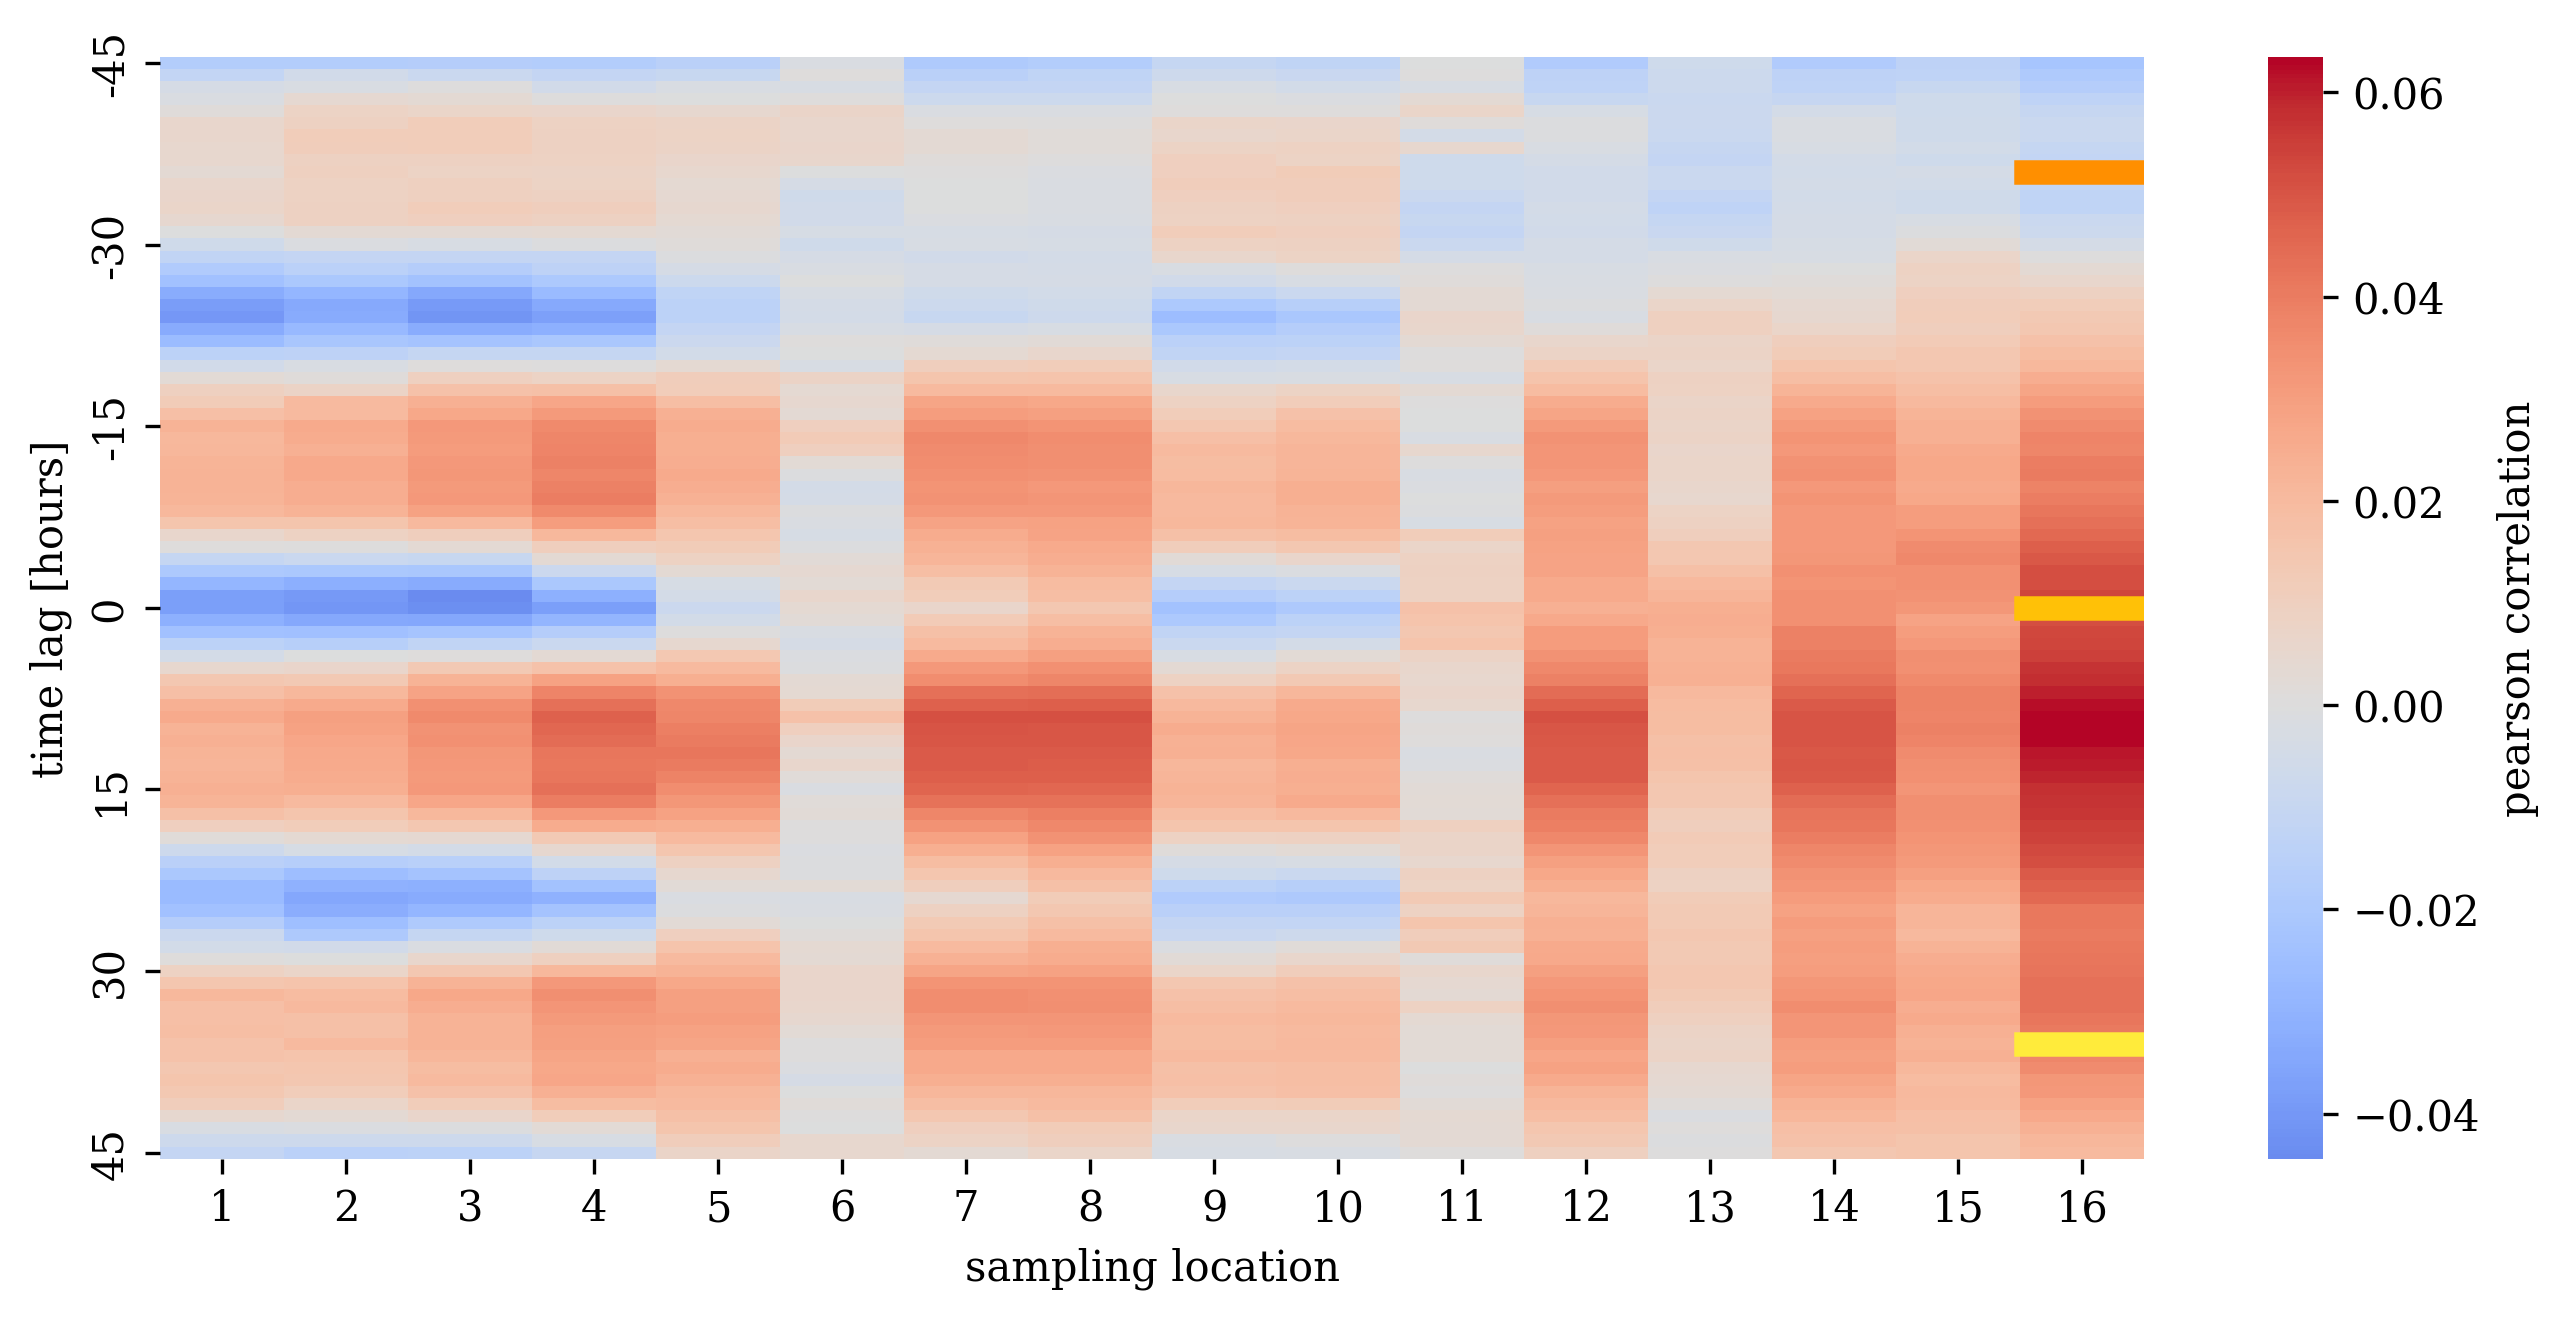

In [24]:
fig, ax = plt.subplots(figsize = (9,4.5), dpi=300) 
lb = sns.heatmap(df_res[[str(i) for i in range(1,17)]], cmap='coolwarm', center=0, yticklabels=15, cbar_kws={'label': 'pearson correlation'})
ax.set_xlabel("sampling location")
ax.set_ylabel("time lag [hours]")

shades_of_yellow = ['#FFEB3B', '#FFC107', '#FF8F00']
ax.add_patch(Rectangle((15, df_res.index.get_loc(-lag_in_hours)), 1, 1, fill=False, edgecolor=shades_of_yellow[2], lw=3))
ax.add_patch(Rectangle((15, df_res.index.get_loc(0)), 1, 1, fill=False, edgecolor=shades_of_yellow[1], lw=3))
ax.add_patch(Rectangle((15, df_res.index.get_loc(lag_in_hours)), 1, 1, fill=False, edgecolor=shades_of_yellow[0], lw=3))

plt.tight_layout()
fig.savefig(os.path.join(plot_path, f"{file_name_prefix}_incidence_cross_correlation.png"), dpi=300)